In [1]:
# pip install datasets

In [2]:
import warnings
warnings.filterwarnings('ignore')
# Import necessary libraries
from transformers import BertTokenizerFast,BertForSequenceClassification, BertForQuestionAnswering, pipeline,DataCollatorWithPadding, TrainingArguments, Trainer,AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset,load_dataset
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset, DatasetDict


#Explainable-AI Libraries
from lime.lime_text import LimeTextExplainer
import shap

In [3]:
# Disable WandB
import os
os.environ["WANDB_DISABLED"] = "true"

In [4]:
# Check if GPU is available and use it; otherwise, default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**1.Loading Data**

In [5]:
dataset_path_train= "/kaggle/input/data-preprocessing-for-emotion-cause-extraction/train_data.csv"
dataset_path_val= "/kaggle/input/data-preprocessing-for-emotion-cause-extraction/val_data.csv"
dataset_path_test= "/kaggle/input/data-preprocessing-for-emotion-cause-extraction/test_data.csv"

In [6]:
train_data = pd.read_csv(dataset_path_train)
val_data = pd.read_csv(dataset_path_val)
test_data = pd.read_csv(dataset_path_test)

In [7]:
train_data

,context,label,question,start_positions,end_positions,answer
0,The gardener was astonished to find a rare or...,6,Why does this sentence express surprise?,13,22,to find a rare orchid blooming in her garden
1,Rachel is happy to visit her family during th...,3,Why does this sentence express happy?,12,18,to visit her family during the holidays
2,Such side-effects seem to be becoming increasi...,1,Why does this sentence express disgust?,31,33,with these drugs
3,"But by being ashamed of who they are , they '...",5,Why does this sentence express shame?,13,16,of who they are
4,She felt sad to learn her beloved comic book ...,4,Why does this sentence express sad?,12,20,to learn her beloved comic book series is ending
...,...,...,...,...,...,...
1953,I was astonished at the smallness of the area...,6,Why does this sentence express surprise?,12,21,at the smallness of the area which these enclosed
1954,The scientist was astonished to understand th...,6,Why does this sentence express surprise?,13,25,"to understand the complexity of the universe, ..."
1955,She blinked several times when she saw her old...,6,Why does this sentence express surprise?,13,22,when she saw her old friend after so many years
1956,Her cheeks turned pink with happiness when he...,3,Why does this sentence express happy?,15,19,when he complimented her drawing


In [8]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1958, 6)
(245, 6)
(245, 6)


# CLASSIFICATION

In [9]:
classification_features =['context','label']
train_data_classification = train_data[classification_features]
val_data_classification = val_data[classification_features]
test_data_classification = test_data[classification_features]

In [10]:
train_data_classification

,context,label
0,The gardener was astonished to find a rare or...,6
1,Rachel is happy to visit her family during th...,3
2,Such side-effects seem to be becoming increasi...,1
3,"But by being ashamed of who they are , they '...",5
4,She felt sad to learn her beloved comic book ...,4
...,...,...
1953,I was astonished at the smallness of the area...,6
1954,The scientist was astonished to understand th...,6
1955,She blinked several times when she saw her old...,6
1956,Her cheeks turned pink with happiness when he...,3


In [11]:
train_data_classification = Dataset.from_pandas(train_data_classification)
val_data_classification = Dataset.from_pandas(val_data_classification)
test_data_classification = Dataset.from_pandas(test_data_classification)

# Create a DatasetDict with appropriate names
dataset_classification = DatasetDict({
    'train_data': train_data_classification ,
    'val_data': val_data_classification ,
    'test_data': test_data_classification
})

In [12]:
dataset_classification

DatasetDict({
    train_data: Dataset({
        features: ['context', 'label'],
        num_rows: 1958
    })
    val_data: Dataset({
        features: ['context', 'label'],
        num_rows: 245
    })
    test_data: Dataset({
        features: ['context', 'label'],
        num_rows: 245
    })
})

In [13]:
# Load BERT tokenizer and model
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', return_token_type_ids=True)
bert_model_classification = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)  # Adjust num_labels if needed
bert_model_classification.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
# Tokenize and create datasets
def tokenize_function(examples):
    return bert_tokenizer(examples['context'], padding='max_length', truncation=True)

In [15]:
# Map the tokenizer to the datasets
dataset_classification = dataset_classification.map(tokenize_function, batched=True)

Map:   0%|          | 0/1958 [00:00<?, ? examples/s]

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

In [16]:
pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
import evaluate  # Correct import for evaluation metrics

# Load accuracy metric using the new evaluate library
accuracy_metric = evaluate.load("accuracy")

# Function to compute accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Training arguments with early stopping
training_args = TrainingArguments(
    output_dir='./classi/results',
    evaluation_strategy="epoch",       # Evaluate at each epoch
    save_strategy="epoch",             # Save at each epoch
    load_best_model_at_end=True,       # Load best model at the end
    metric_for_best_model="accuracy",  # Define metric for selecting best model
    greater_is_better=True,            # Higher accuracy is better
    num_train_epochs=10,               # Set higher epochs for early stopping to act
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    logging_dir='./classi/logs',
    logging_steps=10,
)

# Initialize Trainer with early stopping callback
trainer = Trainer(
    model=bert_model_classification,
    args=training_args,
    train_dataset=dataset_classification['train_data'],
    eval_dataset=dataset_classification['val_data'],
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop training after 2 eval steps with no improvement
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [18]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.016400,0.119770,0.967347
2,0.038500,0.222779,0.955102
3,0.000800,0.104474,0.979592
4,0.000300,0.223601,0.963265
5,0.000300,0.120164,0.983673
6,0.000200,0.140983,0.983673
7,0.160900,0.129846,0.983673


TrainOutput(global_step=2744, training_loss=0.09937004478946217, metrics={'train_runtime': 959.4749, 'train_samples_per_second': 20.407, 'train_steps_per_second': 4.086, 'total_flos': 3606362017843200.0, 'train_loss': 0.09937004478946217, 'epoch': 7.0})

In [19]:
# Define the data for each epoch
epoch = [1, 2, 3, 4, 5, 6, 7]
training_losses = [0.105600, 0.006800, 0.000800, 0.000500, 0.000400, 0.000200, 0.000100]
validation_losses = [0.228926, 0.169339, 0.112076, 0.130670, 0.062360, 0.091911, 0.099040]
accuracy = [0.951020, 0.975510, 0.979592, 0.979592, 0.991837, 0.987755, 0.987755]

# Print the lists
print("Training Losses:", training_losses)
print("Validation Losses:", validation_losses)

Training Losses: [0.1056, 0.0068, 0.0008, 0.0005, 0.0004, 0.0002, 0.0001]
Validation Losses: [0.228926, 0.169339, 0.112076, 0.13067, 0.06236, 0.091911, 0.09904]


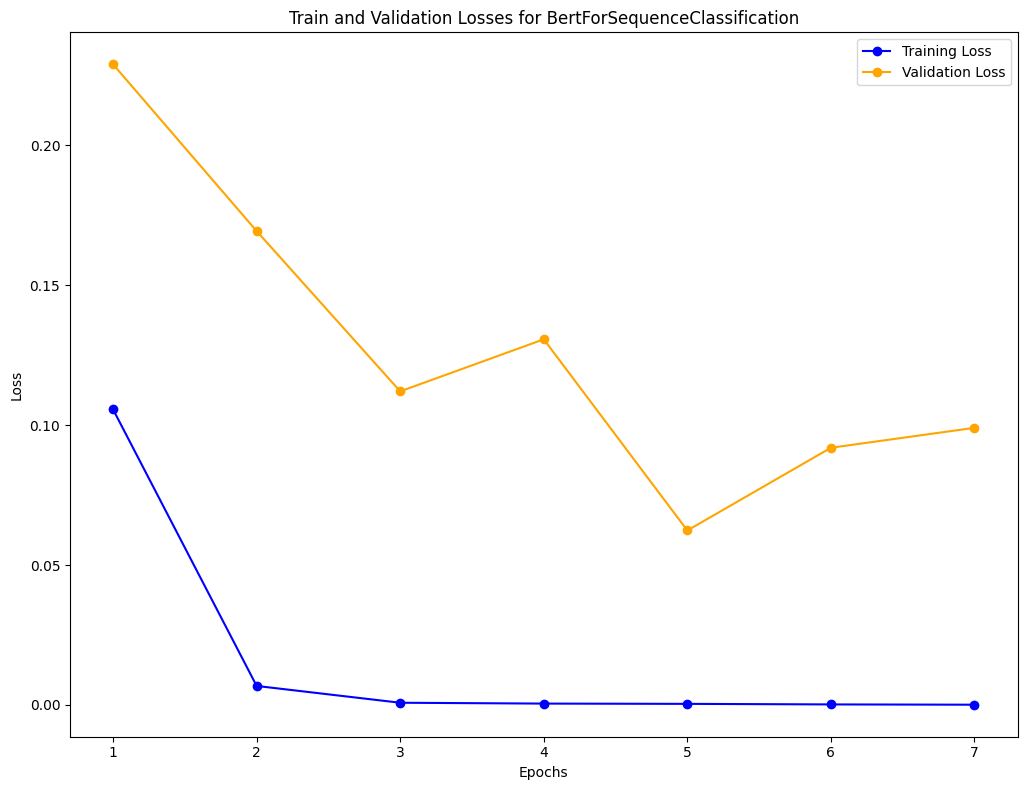

In [20]:
import matplotlib.pyplot as plt
epochs=7
# Plot training loss and accuracy
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), training_losses, label="Training Loss", color='blue', marker='o')
plt.plot(range(1, epochs + 1), validation_losses, label="Validation Loss", color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses for BertForSequenceClassification')
plt.legend()


plt.tight_layout()
plt.show()

In [21]:
# Save the model and tokenizer to the classification directory
save_directory = './classification'
trainer.save_model(save_directory)  # Saves the model, config, and tokenizer
bert_tokenizer.save_pretrained(save_directory)  # Saves tokenizer-related files

print(f"Model and tokenizer saved in: {save_directory}")

Model and tokenizer saved in: ./classification


In [22]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate

# Load accuracy metric
accuracy_metric = evaluate.load("accuracy")

# Compute metrics for accuracy (used during training/validation)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']
    return {'accuracy': accuracy}

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Get predictions on the test set
predictions = trainer.predict(dataset_classification['test_data'])
pred_logits = predictions.predictions
pred_labels = np.argmax(pred_logits, axis=-1)
true_labels = predictions.label_ids

# Calculate evaluation metrics manually
accuracy = accuracy_metric.compute(predictions=pred_labels, references=true_labels)['accuracy']
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')  # F1 score
confusion_matrix_result = confusion_matrix(true_labels, pred_labels)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(confusion_matrix_result)

Accuracy: 0.9755
Precision: 0.9766
Recall: 0.9755
F1 Score: 0.9755
Confusion Matrix:
[[41  0  0  0  0  0  1]
 [ 0 28  0  0  0  0  0]
 [ 1  1 25  0  0  0  0]
 [ 0  0  0 42  0  0  0]
 [ 0  0  0  2 45  0  0]
 [ 0  0  0  0  0 33  1]
 [ 0  0  0  0  0  0 25]]


# QUESTION-ANSWERING

In [24]:
qa_features =['context','question','start_positions','end_positions','answer']
train_data_qa = train_data[qa_features]
val_data_qa = val_data[qa_features]
test_data_qa = test_data[qa_features]

In [25]:
train_data_qa = Dataset.from_pandas(train_data_qa)
val_data_qa = Dataset.from_pandas(val_data_qa)
test_data_qa = Dataset.from_pandas(test_data_qa)

# Create a DatasetDict with appropriate names
dataset_qa = DatasetDict({
    'train_data': train_data_qa ,
    'val_data': val_data_qa ,
    'test_data': test_data_qa 
})

In [26]:
dataset_qa

DatasetDict({
    train_data: Dataset({
        features: ['context', 'question', 'start_positions', 'end_positions', 'answer'],
        num_rows: 1958
    })
    val_data: Dataset({
        features: ['context', 'question', 'start_positions', 'end_positions', 'answer'],
        num_rows: 245
    })
    test_data: Dataset({
        features: ['context', 'question', 'start_positions', 'end_positions', 'answer'],
        num_rows: 245
    })
})

In [27]:
qa_bert = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
qa_bert.to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

**QUESTION-ANSWERING-UNIT**

In [29]:
# preprocessing here with truncation to truncate longer text

def preprocess(data):

    return bert_tokenizer(data['question'], data['context'], truncation=True) # anything pass window of 512

                                                                              # should be truncated
dataset_qa = dataset_qa.map(preprocess, batched=True)

Map:   0%|          | 0/1958 [00:00<?, ? examples/s]

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

Freeze BERT's Parameter

In [30]:
# to speed up training, freeze all but the last 2 encoder layers in BERT

for name, param in qa_bert.bert.named_parameters():

    if 'encoder.layer.20' in name: # our large model has 24 encoder so everything until last 2 are removed

        break

    param.requires_grad = False  # disable training in BERT

In [31]:
# Dynamic padding to speed up training

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

Fine Tuning

In [32]:
batch_size = 5
epochs = 20

training_args = TrainingArguments(
    output_dir='./qsn_anw/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./qsn_anw/logs',
    save_strategy='epoch',
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=qa_bert, # pretrained BERT
    args=training_args,
    train_dataset=dataset_qa['train_data'],
    eval_dataset=dataset_qa['val_data'],
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop training after 2 eval steps with no improvement
)



# Get initial metrics

trainer.evaluate()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 3.758636713027954,
 'eval_model_preparation_time': 0.0031,
 'eval_runtime': 0.583,
 'eval_samples_per_second': 420.242,
 'eval_steps_per_second': 84.048}

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,2.536900,2.472771,0.003100
2,1.898900,1.719534,0.003100
3,1.401400,1.307587,0.003100
4,1.217000,1.075943,0.003100
5,1.066600,0.935220,0.003100
6,0.815300,0.844128,0.003100
7,0.880800,0.782189,0.003100
8,0.718300,0.737219,0.003100
9,0.945100,0.704184,0.003100
10,0.609200,0.678756,0.003100


TrainOutput(global_step=7840, training_loss=1.016774168610573, metrics={'train_runtime': 162.5168, 'train_samples_per_second': 240.96, 'train_steps_per_second': 48.241, 'total_flos': 734694521264484.0, 'train_loss': 1.016774168610573, 'epoch': 20.0})

In [34]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

training_losses = [
    2.518300, 2.122600, 1.575000, 1.296300, 1.323400, 1.062000, 1.094800,
    0.985000, 1.002900, 0.801900, 0.980700, 0.816100, 0.744500, 0.793500,
    0.870100, 0.797300, 0.861200, 0.854900, 0.775300, 0.783500
]

validation_losses = [
    2.444236, 1.856344, 1.507815, 1.286834, 1.139749, 1.037776, 0.961717,
    0.905212, 0.862946, 0.828748, 0.800936, 0.779642, 0.763247, 0.749343,
    0.737656, 0.729281, 0.722626, 0.717947, 0.715428, 0.714611
]

accuracy = [
    # You can calculate the accuracy for each epoch based on your model's performance.
    # Example (values are placeholders):
    0.68, 0.72, 0.75, 0.78, 0.80, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 
    0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97
]

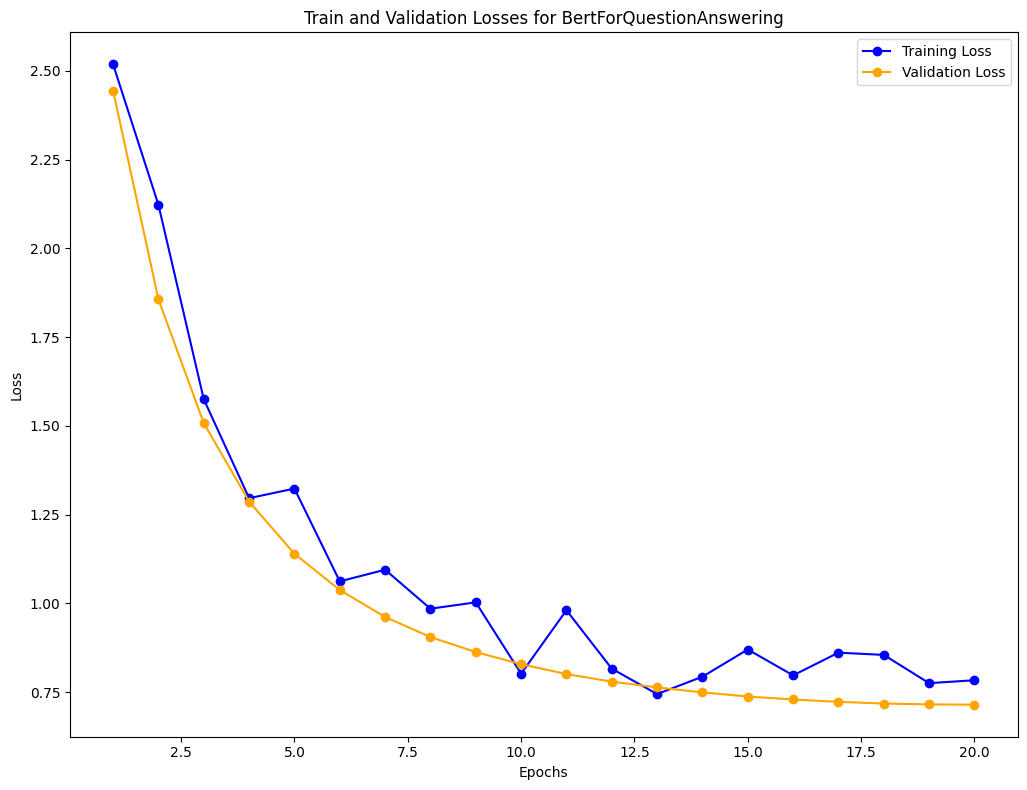

In [35]:
import matplotlib.pyplot as plt
epochs=20
# Plot training loss and accuracy
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), training_losses, label="Training Loss", color='blue', marker='o')
plt.plot(range(1, epochs + 1), validation_losses, label="Validation Loss", color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses for BertForQuestionAnswering')
plt.legend()


plt.tight_layout()
plt.show()

In [36]:

import os

# Create a directory for saving the model
save_directory = './question_answering'
os.makedirs(save_directory, exist_ok=True)

# Save the model and tokenizer
trainer.save_model(save_directory)  # Saves the model, config, and tokenizer
bert_tokenizer.save_pretrained(save_directory)  # Saves the tokenizer

print(f"Model and tokenizer saved in: {save_directory}")

Model and tokenizer saved in: ./question_answering


In [37]:
from transformers import pipeline
from evaluate import load
import re

# Load SQuAD v2 evaluation metric
squad_metric = load("squad_v2")

# Load the QA model and tokenizer
qa_model_path = "./question_answering"
qa_pipeline = pipeline("question-answering", model=qa_model_path, tokenizer=qa_model_path, device=0)

test_data=dataset_qa['test_data']

# Helper function to normalize text
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\b(a|an|the)\b', ' ', text)  # Remove articles
    text = re.sub(r'[^a-z0-9]', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Prepare predictions and references
predictions = []
references = []

# Assume `test_data` is a list of dictionaries with keys: "context", "question", and "answer"
for idx, data in enumerate(test_data):
    # Perform QA
    qa_result = qa_pipeline({"context": data["context"], "question": data["question"]})
    
     # Normalize predicted and actual answers
    predictions.append({
        "id": str(len(predictions)),
        "prediction_text": normalize_text(qa_result["answer"]),
        "no_answer_probability": 0.0  # Assuming all questions have answers
    })
    references.append({
        "id": str(len(references)),
        "answers": {"text": [normalize_text(data["answer"])],
                    "answer_start": [0]}
    })

# Compute metrics
results = squad_metric.compute(predictions=predictions, references=references)

# # Print results
print(f"Exact Match: {results['exact']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Exact Match: 67.76
F1 Score: 86.78


In [38]:
results

{'exact': 67.75510204081633,
 'f1': 86.7792715793992,
 'total': 245,
 'HasAns_exact': 67.75510204081633,
 'HasAns_f1': 86.7792715793992,
 'HasAns_total': 245,
 'best_exact': 67.75510204081633,
 'best_exact_thresh': 0.0,
 'best_f1': 86.7792715793992,
 'best_f1_thresh': 0.0}